In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np

In [6]:
from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

N = 1000
M = 30
K = 2
NUM_SPLITS = 3

Ds = [] # data
Xs = [] # features
Ls = [] # noisy labels
Ys = [] # true labels
for _ in range(NUM_SPLITS):
    L, Y, _ = generate_single_task_unipolar(
        N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
        class_balance=[0.3, 0.7], polarity_balance=None, seed=1)
    
    X, D = gaussian_bags_of_words(Y, vocab1k)
    
    Ls.append(L)
    Ys.append(Y)
    Ds.append(D)
    Xs.append(X)

In [7]:
search_space = {
    'n_epochs': 500,
    'l2': [0.0, 0.01, 0.1],
    'lr': {'range': [0.0001, 1], 'scale': 'log'},
}

In [8]:
# First run basic grid search / random search
from metal.label_model import LabelModel
from metal.tuner import ModelTuner

def run_random_search(seed=123):
    tuner = ModelTuner(LabelModel)
    init_args = []
    train_args = [Ls[0]]
    model, best_config, run_stats_random_search = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                                               search_space, max_search=50, metric='f1')
    return run_stats_random_search

In [9]:

# Hyperband
from metal.label_model import LabelModel
from metal.tuner import HyperbandTuner

def run_hyperband(seed=123):
    tuner = HyperbandTuner(LabelModel, hyperband_epochs_budget=2000, seed=seed)
    init_args = []
    train_args = [Ls[0]]
    model, best_config, run_stats_hyperband = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                                           search_space, metric='f1')
    return run_stats_hyperband

In [10]:
%%capture
seeds = [123, 234, 456, 567, 678]
runstats_hyperband = []
runstats_rs = []
for seed in seeds:
    runstats_rs.append(run_random_search(seed=seed))
    runstats_hyperband.append(run_hyperband(seed=seed))

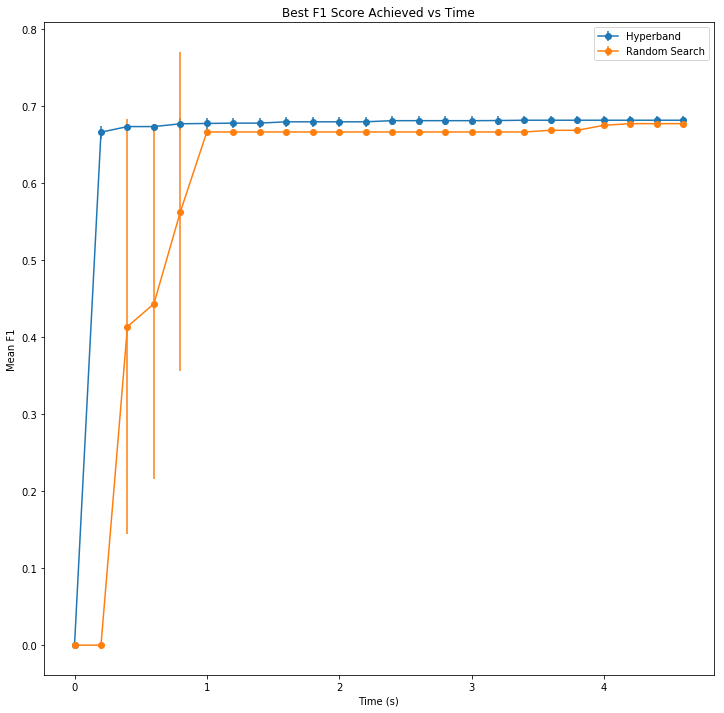

In [11]:
%matplotlib inline

# Plot random search vs hyperband run stats
import matplotlib.pyplot as plt
import matplotlib as mpl


xs_hyperband = [[x["time_elapsed"] for x in z] for z in runstats_hyperband]
ys_hyperband = [[x["best_score"] for x in z] for z in runstats_hyperband]
xs_rs = [[x["time_elapsed"] for x in z] for z in runstats_rs]
ys_rs = [[x["best_score"] for x in z] for z in runstats_rs]

# Extract min and max times for segmented times
flat_xs_hyperband = [item for sublist in xs_hyperband for item in sublist]
flat_xs_rs = [item for sublist in xs_rs for item in sublist]
min_time, max_time = 0, max(flat_xs_hyperband + flat_xs_rs)


# Get list of best scores at time
def get_best_scores_at_time(all_runstats, target_time):
    best_scores = []
    for runstats in all_runstats:
        best_score = 0        
        times = [x["time_elapsed"] for x in runstats]
        scores = [x["best_score"] for x in runstats]
        for time, score in zip(times, scores):
            if time < target_time:
                best_score = score
        best_scores.append(best_score)
    return best_scores
        
# Extract best scores per segment
segments = list(np.arange(0, max_time, .2))
hyperband_scores = [get_best_scores_at_time(runstats_hyperband, t) for t in segments]
rs_scores = [get_best_scores_at_time(runstats_rs, t) for t in segments]

# Extract means and error bars
mean_hyperband_scores = [np.mean(x) for x in hyperband_scores]
mean_rs_scores = [np.mean(x) for x in rs_scores]
hyperband_stds = [np.std(x) for x in hyperband_scores]
rs_stds = [np.std(x) for x in rs_scores]

#plt.plot(segments, mean_hyperband_scores, label="Hyperband", marker="o")
#plt.plot(segments, mean_rs_scores, label="Random Search", marker="o")
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.errorbar(segments, mean_hyperband_scores, hyperband_stds, label="Hyperband", marker="o")
plt.errorbar(segments, mean_rs_scores, rs_stds, label="Random Search", marker="o")
plt.legend(loc="best")
plt.title("Best F1 Score Achieved vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean F1")